In [8]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, plot

import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia as has

# 1 Strain Model

Build SAM and calculate strains

Make the semi-analytic model object.

In [9]:
dur = 10.0*YR
cad = 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
# sam = holo.sam.Semi_Analytic_Model() 
sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hard = holo.hardening.Hard_GW

Calculate strains.

In [10]:
fobs_orb_edges = fobs_edges / 2.0 
fobs_orb_cents = fobs/ 2.0
# edges
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
edges[-1] = fobs_orb_edges
# integrate for number
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges)) 
hc_ss, hc_bg = ss.ss_gws(edges, number, realize=30, 
                                        loudest = 1, params = False) 


15:01:46 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
15:01:46 INFO : Stalled SAM bins based on GMT: 3.20e+03/8.00e+03 = 4.00e-01 [sam.py:static_binary_density]
15:01:46 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
15:01:46 INFO : 	dens bef: (1.28e-114, 1.11e-55, 2.00e-13, 1.79e-03, 1.69e-02, 3.04e-02, 4.47e-02) [sam.py:static_binary_density]
15:01:46 INFO : Scatter added after 0.152363 sec [sam.py:static_binary_density]
15:01:46 INFO : 	dens aft: (6.08e-15, 1.26e-08, 1.91e-06, 1.96e-03, 1.73e-02, 3.03e-02, 4.25e-02) [sam.py:static_binary_density]
15:01:46 INFO : 	mass: 8.91e-02 ==> 8.88e-02 || change = -3.5501e-03 [sam.py:static_binary_density]
15:01:46 INFO : zeroing out 3.20e+03/8.00e+03 = 4.00e-01 systems stalled from GMT [sam.py:static_binary_density]
15:01:46 INFO : fraction of coalesced binaries: 9.44e+03/2.00e+05 = 4.72e-02 [sam.py:dynamic_binary_number]
15:01:46 WARNING : WARNING: _stalled_ binaries are not being ac

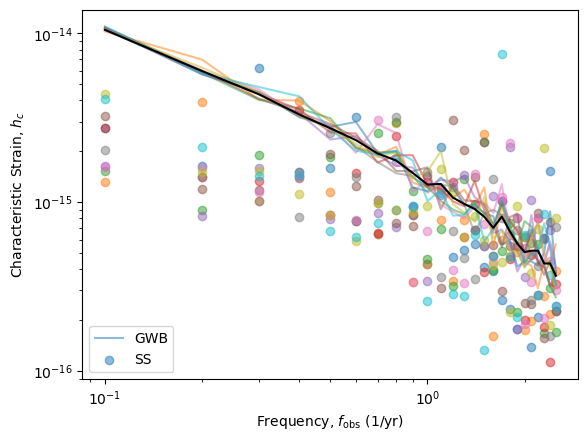

In [11]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_bg = 'GWB'
        label_ss = 'SS'
    else:
        label_bg = None
        label_ss = None
    plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg)
    plt.scatter(fobs*YR, hc_ss[:,rr], alpha=0.5, label=label_ss)
plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
plt.legend()


In [12]:
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# # example 5
# dur = 10.0*YR
# cad = .2*YR

# 2 Pulsar Setup
## 2.1 Make pulsars with hasasia

In [13]:
num = 20
phis = np.random.uniform(0, 2*np.pi, size = num)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = num)
# sim uses dur in yrs and cad in #/yr
# make list of hasasia.Pulsar objects
pulsars = hsim.sim_pta(timespan = dur/YR, cad = 1/(cad/YR), sigma = 1e-7,
                      phi = phis, theta = thetas)
print(pulsars[0].__dict__.keys())

dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])


In [14]:
print(thetas)
print(phis)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633]
[2.17544071 5.07106073 4.48530046 1.11624349 3.23692551 0.02368707
 4.24055853 2.06526217 4.55676696 3.32116669 2.05019174 0.24968121
 0.17312852 2.07875214 2.74061456 1.64633674 2.07255383 3.75749457
 6.1680957  6.26998494]


Make spectra

In [15]:
spectra = []

for pul in pulsars:
    spec = hsen.Spectrum(pul, freqs=fobs) # spectrum object
    spec.NcalInv # calculate inverse noise weighted transmission function along the way
    spectra.append(spec)
    # add white noise and add red noise here? 
    # add_noise_power(noise)
    # add_red_noise_power(A=None, gamma=None, vals=False)
    # add_white_noise_power(sigma=None, dt = None, vals=False)

## 2.2 Overlap Reduction Function

Using Rosado eq.s:
$$ \Gamma_{ij} = \frac{3}{2} \gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4} \gamma_{ij} + \frac{1}{2} + \frac{1}{2}\delta_{ij} $$
$$ \gamma_{ij} = [1-\cos (\theta_{ij})]/2$$

In [16]:
def gammaij_from_thetaij(theta_ij):
    """ Calcualte gamma_ij for two pulsars of relative angle theta_ij.
    
    Parameters
    ----------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsars.

    Returns
    -------
    gamma_ij : scalar 
        [1 - cos(theta_ij)]/2

    """
    return (1-np.cos(theta_ij))/2


def dirac_delta(i,j):
    """ Calculate the dirac delta function of i,j.
    Parameters
    ----------
    i : int
    j : int

    Returns
    ------- 
    dirac_ij : int
        Dirac delta function of i and j

    """
    if(i==j): return 1
    else: return 0

def relative_angle(theta_i, phi_i, theta_j, phi_j):
    """ Calculate relative angle between two pulsars i and j.
    
    Parameters
    ----------
    theta_i : scalar 
        Polar angular position in the sky of the ith pulsar.
    phi_i : scalar
        Azimuthal angular position in the sky of the ith pulsar.
    theta_j : scalar 
        Polar angular position in the sky of the jth pulsar.
    phi_j : scalara
        Azimuthal angular position in the sky of the jth pulsar.

    Returns
    -------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsar.

    """
    
    theta_ij = np.arccos(np.cos(phi_i)*np.cos(phi_j) 
                      + np.sin(phi_i)*np.sin(phi_j)*np.cos(theta_i - theta_j))
    
    return theta_ij

def orf_ij(i, j, theta_ij):
    """ Calculate the overlap reduction function Gamma_i,j as a function of theta_i, theta_j, i, and j.
    
    Parameters
    ----------
    i : int
        index of the ith pulsar
    j : int
        index of the jth pulsar
    theta_ij : scalar
        relative angular position between the ith and jth pulsars

    Returns
    -------
    Gamma : scalar
        The overlap reduction function of the ith and jth pulsars.


    Follows Rosado et al. 2015 Eq. (24)
    """
    dirac_ij = dirac_delta(i, j)
    gamma_ij = gammaij_from_thetaij(theta_ij)
    
    Gamma = (3/2 * gamma_ij *np.log(gamma_ij)
            - 1/4 * gamma_ij
            + 1/2 + dirac_ij)
    if(np.isnan(Gamma) and i!=j):
        print('Gamma_%d,%d is nan, set to 0' % (i,j))
        return 0
    return Gamma


def orf_all(pulsars):
    """ Calculate the overlap reduction function matrix Gamma for a list of hasasia.Pulsar objects

    Paramters
    ---------
    pulsars : (P,) list of hasasia.Pulsar objects.

    Returns
    -------
    Gamma : (P,P) NDarray
        Overlap reduction function matrix for all pulsars i,j with j>i
        Only for j>1, 0 for j<=i

    """

    Gamma = np.zeros((len(pulsars), len(pulsars)))
    for ii in range(len(pulsars)):
        for jj in range(len(pulsars)):
            if (jj>ii): # 0 otherwise, allows sum over all
                # calculate angle between two vectors.
                theta_ij =  relative_angle(pulsars[ii].theta, pulsars[ii].phi,
                                           pulsars[jj].theta, pulsars[jj].phi)
                print('theta_ij', theta_ij)
                # find ORF
                Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)
    
    return Gamma


In [17]:
Gamma = orf_all(pulsars)
print(Gamma)

theta_ij 2.895620026645731
theta_ij 2.30985974989596
theta_ij 1.05919722187072
theta_ij 1.0614848054711667
theta_ij 2.151753637076432
theta_ij 2.0651178241640604
theta_ij 0.11017853698751681
theta_ij 2.3813262545906
theta_ij 1.145725986804071
theta_ij 0.1252489687629109
theta_ij 1.9257594956410031
theta_ij 2.002312187823603
theta_ij 0.09668856827424069
theta_ij 0.5651738512717953
theta_ij 0.5291039719007917
theta_ij 0.10288688184034728
theta_ij 1.5820538614209139
theta_ij 2.2905303136174697
theta_ij 2.1886410753918986
theta_ij 0.5857602767497712
theta_ij 2.3283680586631355
theta_ij 1.8341352211745643
theta_ij 1.2358116434574238
theta_ij 0.8305022024816706
theta_ij 3.0057985636332467
theta_ij 0.5142937720551312
theta_ij 1.74989403984166
theta_ij 3.020868995408642
theta_ij 1.4618057848928523
theta_ij 1.3852530927102522
theta_ij 2.992308594919972
theta_ij 2.3304461753739356
theta_ij 2.8584613086330637
theta_ij 2.9985069084860783
theta_ij 1.3135661652248172
theta_ij 1.097034966916386
theta

Using hasasia.GWBSensitivityCurve

In [18]:
scGWB = hsen.GWBSensitivityCurve(spectra) # orf='hd'
print(scGWB.__dict__.keys())
print(scGWB.chiIJ) 

dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ'])
[ 0.23135882  0.06715881 -0.086604   -0.08739795  0.0094281  -0.02144039
  0.47287207  0.0928247  -0.11324849  0.46645831 -0.06751107 -0.04289627
  0.47818926  0.18266651  0.20777036  0.47579824 -0.14362945  0.06012418
  0.02284631  0.16850217  0.07386454 -0.09403833 -0.13353867  0.01609754
  0.24426225  0.21816032 -0.11487992  0.24546104 -0.1516897  -0.15062786
  0.24307187  0.0746153   0.22541507  0.24363254 -0.14496969 -0.09911372
 -0.1261504   0.23402578 -0.13576485 -0.09738004  0.40226181  0.10639951
  0.48692324 -0.11801344  0.11160348 -0.02753134 -0.05319116  0.10170123
 -0.11604103  0.22198786  0.10386449  0.07572749 -0.12859056 -0.10673053
 -0.00177079 -0.0977024   0.24990672 -0.04274517  0.22265396  0.02879698
 -0.03591058 -0.00301198 -0.04009109 -0.04869616 -0.13817363  0.2070778
 -0.04598151  0.17626352 -0.13270951 -0.10876882  0.24839782 -0.06584845
 -0.11

## 2.3 Noise spectral density $P_i$ 
$$ P_i = 2 \Delta t \sigma_i^2 $$

In [19]:
def _white_noise(delta_t, sigma_i):
    """ Calculate the white noise for a given pulsar 2 /Delta t sigma_i^2
    
    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigma_i : scalar
        Error/stdev/variance? for the ith pulsar, in seconds.

    Returns
    -------
    P_i : scalar
        Noise spectral density for the ith pulsar, for bg detection.
        For single source detections, the noise spectral density S_i must also 
        include red noise from all but the loudest single sources, S_h,rest. 
        Rosado et al. 2015 Eq. (23)

    """
    P_i = 2 * delta_t * sigma_i**2
    return P_i

In [20]:
sigmas = np.zeros(num)
for ii in range(num):
    sigmas[ii] = np.mean(pulsars[ii].toaerrs)
noise = _white_noise(cad, sigmas) 
print('P_i =', noise, 's^3 =', noise/YR**3,' yrs^3')

P_i = [1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07] s^3 = [4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30]  yrs^3


# 3 Background Signal
## 3.1 Power Spectral Density
$S_h$, the one-sided power spectral density of the GW signal in the timing residuals
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$

In [21]:
def power_spectral_density(hc_bg, freqs):
    """ Calculate the spectral density S_h(f_k) ~ S_h0(f_k) at the kth frequency

    Parameters
    ----------
    hc_bg : (F,) 1D array of scalars
        Characteristic strain of the background at each frequency. 
    freqs : (F,) 1Darray of scalars
        Frequency bin centers corresponding to each strain

    Returns
    -------
    S_h : (F,) 1Darray of scalars
        Actual (S_h) or ~construction (S_h0) value of the background spectral density. 
        In units of [freqs]^-3
    """

    S_h = hc_bg**2 / (12 * np.pi**2 * freqs**3)
    return S_h

In [22]:
Sh_bg = power_spectral_density(hc_bg[:,0], fobs) # spectral density of bg, using 0th realization
Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015
print(Sh_bg)
print(scGWB.S_eff)

[3.08558526e-05 1.08218247e-06 1.96492496e-07 4.21937452e-08
 1.65799507e-08 1.09462512e-08 2.93349931e-09 2.10105007e-09
 5.40028539e-10 3.58074439e-10 3.88855022e-10 2.23677749e-10
 1.11488502e-10 8.83151083e-11 5.80001352e-11 4.39535188e-11
 1.69686087e-11 1.60659715e-11 6.63995242e-12 6.58788086e-12
 5.68716101e-12 4.40703483e-12 5.47362136e-12 1.48712730e-11
 2.38659095e-12]
[2.08622738e-22 2.33077191e-22 4.88526259e-22 8.52850285e-22
 1.32577816e-21 1.91295083e-21 2.63410804e-21 3.58201779e-21
 5.89920825e-21 2.32066551e+09 8.83092686e-21 8.04572478e-21
 9.04623960e-21 1.03377544e-20 1.17862756e-20 1.33599734e-20
 1.50479088e-20 1.68454736e-20 1.87504776e-20 4.21432619e-20
 2.28789576e-20 2.51016885e-20 2.74300437e-20 2.98642612e-20
 3.24047973e-20]


## 3.2 mu_1
$$\mu_1 = 1\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{[P_i + S_{h0}] [P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2} $$


In [23]:
def mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    mu_1B = 0
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    mu_1B += ((Gamma_ij**2 * Sh * Sh0)
                            /((P_i+Sh0) * (P_j+Sh0) 
                                + Gamma_ij**2 * Sh0**2))
    mu_1B *= 2
    return mu_1B

def mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for jj>ii, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    
    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis] **2 
            * Sh_bg[np.newaxis, np.newaxis, :]
            * Sh0_bg[np.newaxis, np.newaxis, :])
    denom = ((noise[:, np.newaxis, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               * (noise[np.newaxis, :, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis, np.newaxis, :]**2)
    
    # should not need this part if Gamma takes all jj<=ii parts to zero
    sum = np.sum(numer/denom)
    mu_1B = 2*sum
    return mu_1B


In [24]:
mu_1B_loops = mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(mu_1B_loops, mu_1B)

34.350750176063606 34.35075017606365


## 3.3 sigma_0
$$ \sigma_0^2 = 2\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 P_i P_j  }{\big[ [P_i + S_{h0}] [P_j +S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$



In [25]:
def sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        
    
    Follows Eq. (A17) from Rosado et al. 2015.
    """

    sigma_0B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh0 = Sh0_bg[kk]
                    numer = Gamma_ij**2 * Sh0**2 * P_i * P_j
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_0B += (numer/denom)
    
    sigma_0B = np.sqrt(2*sigma_0B)
    return sigma_0B


def sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        

    Follows Eq. (A17) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis])
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_0B = np.sqrt(2*sum)
    return sigma_0B



In [26]:
sigma_0B_loops = sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_0B_loops, sigma_0B)

1.3627094782668556 1.3627094782668567


## 3.4 sigma_1
$$ \sigma_1^2 = 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 \big[ [P_i + S_h] [P_j + S_h] + \Gamma_{ij}^2 S_h^2   \big]  }{\big[[P_i + S_{h0}][P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$

In [27]:
def sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    sigma_1B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    numer = (Gamma_ij**2 * Sh0**2 * 
                             ((P_i + Sh) * (P_j + Sh) 
                              + Gamma_ij**2 * Sh**2))
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_1B += (numer/denom)
    
    sigma_1B = np.sqrt(2*sigma_1B)
    return sigma_1B


def sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * ((noise[:,np.newaxis,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                * (noise[np.newaxis,:,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                + Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2))
             
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_1B = np.sqrt(2*sum)
    return sigma_1B



In [28]:
sigma_1B_loops = sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_1B_loops, sigma_1B)

5.860951302993705 5.860951302993708


## 3.5 SNR Check
$$S/N_B \equiv \frac{\mu_1}{ \sigma_1} = \Bigg[ 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h^2}{P_iP_j + S_h[P_i + P_j] + S_h^2[1+\Gamma_{ij}^2]}   \Bigg]^{1/2} \quad\quad\quad(\mathrm{A}19)$$

In [29]:
def SNR_bg_B(noise, Gamma, Sh_bg):
    """ Calculate S/N_B for the background, using P_i, Gamma, S_h and S_h0
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P,) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    SNR_B : Scalar
        Signal to noise ratio assuming the B statistic
        

    Follows Eq. (A19) from Rosado et al. 2015.
    """


    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2
    denom = (noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis]
             + Sh_bg[np.newaxis,np.newaxis,:] * (noise[:,np.newaxis,np.newaxis]+noise[np.newaxis,:,np.newaxis])
             + Sh_bg[np.newaxis,np.newaxis,:]**2 * (1 + Gamma[:,:,np.newaxis]**2))

    sum = np.sum(numer/denom)
    SNR_B = np.sqrt(2*sum)
    return SNR_B

    

In [30]:
SNR_B = SNR_bg_B(noise, Gamma, Sh_bg)
print(SNR_B, mu_1B/sigma_1B)

5.860951302993708 5.860951302993708


compare to hasasia, where they get SNR as a function of $$S_h = \frac{3H_0^2}{2\pi^2} \frac{\Omega_\mathrm{gw}(f)}{f^3}$$ in units of strain^2/Hz, where $\Omega_{gw}=\frac{2\pi^2}{3\;H_0^2}f^3\;S_I$ 

In [31]:
print(scGWB.Omega_gw.shape)
print(scGWB._H_0.to('Hz'))

(25,)
2.3333610883999426e-18 Hz


In [60]:
def _Sh_hasasia_generic_bg(scGWB):
    """ Calculate the signal strain power spectral density, 
        `Sh` for hasasia's SNR calculation
        
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    Sh_h : (F,) 1Darray
        Sh as used in hasasia's SNR calculation, for each frequency.
    
    """
    freqs = scGWB.freqs
    H0 = scGWB._H_0.to('Hz').value
    Omega_gw = scGWB.Omega_gw
    Sh_h = 3*H0**2 / (2*np.pi**2) * Omega_gw / freqs**3
    return Sh_h

def SNR_hasasia_generic_bg(scGWB):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    SNR_h : scalar
        Signal to noise ratio from hasasia.
    """
    Sh_h = _Sh_hasasia_generic_bg(scGWB)
    SNR_h = scGWB.SNR(Sh_h)
    return SNR_h
    


In [61]:
SNR_hg = SNR_hasasia_generic_bg(scGWB)

print(SNR_hg, SNR_B, mu_1B/sigma_1B) # close enough?

6.928203230275509 5.860951302993708 nan


We could also use the real characeristic strains with equation (56)
$$h_c(f) \equiv \sqrt{f S_h(f)}$$
$$S_h{f} = h_c(f)^2/f$$

In [62]:
def _Sh_hasasia_modeled_bg(freqs, hc_bg):
    """ Calculate Sh for hsen.GWBSensitivityCurve.SNR(Sh) from a 
    modeled GWB characteristic strain.
    
    Parameters
    ----------
    freqs : (F,) 1Darray
        Frequencies of char strain.
    hc_bg : (F,R,) NDarray
        GWB characteristic strain for each frequency and realization.
    
    Returns
    -------
    Sh_h : (F,R,) NDarray
        Sh as used in hasasia's SNR calculation, for each frequency.
    """

    Sh_h = hc_bg**2 / freqs[:,np.newaxis]
    return Sh_h    

def SNR_hasasia_modeled_bg(scGWB, hc_bg):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
    hc_bg : (F,R,) NDarray
        Realistic characteristic strain of the background.
        
    Returns
    -------
    SNR_h : (R,) 1Darray)
        Signal to noise ratio from hasasia, for each realization.
    """
    Sh_h = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
    SNR_h = np.zeros(len(hc_bg[0]))
    for rr in range(len(hc_bg[0])):
        SNR_h[rr] = scGWB.SNR(Sh_h[:,rr])
    return SNR_h

In [63]:
SNR_hr = SNR_hasasia_modeled_bg(scGWB, hc_bg)
print(SNR_hr)

[178.75489282 166.02751156 177.39644192 181.75676154 173.59245131
 179.52412928 174.19652461 169.84343896 169.90332056 185.93363458
 173.32532583 168.37351994 165.40849242 167.48716246 169.56803732
 182.07427368 167.27150653 169.7943306  178.18025856 161.34034582
 162.49458979 170.24759159 163.55314557 162.64847777 178.4426061
 167.62158522 171.68672715 169.50099728 185.4446152  166.7451214 ]


In [64]:
Sh_hg = _Sh_hasasia_generic_bg(scGWB)
Sh_hr = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
print(Sh_hg)
print(np.mean(Sh_hr, axis=1))

[2.08622738e-22 2.33077191e-22 4.88526259e-22 8.52850285e-22
 1.32577816e-21 1.91295083e-21 2.63410804e-21 3.58201779e-21
 5.89920825e-21 2.32066551e+09 8.83092686e-21 8.04572478e-21
 9.04623960e-21 1.03377544e-20 1.17862756e-20 1.33599734e-20
 1.50479088e-20 1.68454736e-20 1.87504776e-20 4.21432619e-20
 2.28789576e-20 2.51016885e-20 2.74300437e-20 2.98642612e-20
 3.24047973e-20]
[3.50575970e-20 5.85304927e-21 2.03296166e-21 9.65266108e-22
 4.89650190e-22 2.92985836e-22 1.93354660e-22 1.33063933e-22
 8.23706695e-23 5.60598208e-23 4.82731199e-23 3.91927193e-23
 2.83421351e-23 1.93012447e-23 1.60827026e-23 1.09078455e-23
 1.48890443e-23 7.85304046e-24 6.69990597e-24 5.73488085e-24
 5.59035243e-24 4.11530438e-24 2.97482951e-24 3.94577235e-24
 2.11406492e-24]


most look reasonably close, but no idea why the generic gives a really high Sh at just one frequency.

## 3.6 Detection Probability
$$ \gamma_{bg} = \frac{1}{2} \mathrm{erfc} \big[ \frac{\sqrt{2} \sigma_0 \mathrm{erfc}^{-1}(2\alpha_0) - \mu_1}{\sqrt{2} \sigma_1}\big]

In [34]:
ALPHA0 = 0.001 # false alarm probability (FAP)

def bg_detection_probability(sigma_0, sigma_1, mu_1, alpha_0):
    """ Calculate the background detection probability, gamma_bg.

    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of stochastic noise processes.
    sigma_1 : scalar
        Standard deviation of GWB PDF.
    mu_1 : scalar
        Mean of GWB PDF.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    dp_bg : scalar
        Background detection probability.

        
    Follows Rosado et al. 2015 Eq. (15)
    """
    temp = ((np.sqrt(2) * sigma_0 * sp.special.erfcinv(2*alpha_0) - mu_1)
            /(np.sqrt(2) * sigma_1))
    dp_bg = .5 * sp.special.erfc(temp)
    return dp_bg

In [35]:
dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)
print(dp_bg)

0.9999998644122013


In [36]:
def detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg, return_all = False):
    """ Calculate the background detection probability, and all intermediary steps.

    Parameters
    ----------
    THETAS : (P,) 1Darray of scalars
        Latitudinal angular position of each pulsar in radians.
    PHIS: (P,) 1Darray of scalars
        Longitudinal angular position of each pulsar in radians.
    SIGMAS : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    return_all : Bool
        Whether to return all parameters or just dp_bg

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar

    """
    # Overlap Reduction Function
    num = len(THETAS) # number of pulsars, P
    Gamma = np.zeros((num, num)) # (P,P) 2Darray of scalars, Overlap reduction function between all puolsar
    for ii in range(num):
        for jj in range(num):
            theta_ij =  relative_angle(THETAS[ii], PHIS[ii],
                                        THETAS[jj], PHIS[jj])
            # find ORF
            Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)

    # Spectral Density
    Sh_bg = power_spectral_density(hc_bg[:], fobs) # spectral density of bg, using 0th realization
    Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015

    # Noise 
    noise = _white_noise(cad, SIGMAS) 

    mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)

    if(return_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg

# Full Walkthrough

In [37]:
# # example 5
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# dur = 10.0*YR
# cad = .2*YR

Print Info

In [38]:
num_pulsars = 40
THETAS = np.linspace(0.001, 2*np.pi, num_pulsars) # (P,) 1Darray of scalars, angular sky position of each pulsar
PHIS = np.linspace(0.001, np.pi, num_pulsars)
SIGMAS = np.linspace(1e-6, 2e-6, num_pulsars) # (P,) 1Darray of scalars, sigma_i of each pulsar
ALPHA0 = 0.001
dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B = \
    detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg[:,1], return_all=True)
print('Number of pulsars:',num_pulsars)
print('\nOVERLAP')
print('thetas (pi):\t%s' % str(holo.utils.stats(THETAS/np.pi)))
print('Gamma:\t%s' % str(holo.utils.stats(Gamma)))
# print('Gamma:\t', Gamma)

print('\nNOISE')
print('cadence (s): \t%.2e' % cad)
print('sigmas (s): %s', str(holo.utils.stats(SIGMAS)))
print('P_i (s^3):\t%s' % str(holo.utils.stats(noise)))

print('\nSIGNAL')
print('fobs (nHz): \t%s' % str(holo.utils.stats(fobs*10**9)))
print('hc_bg:   \t%s' % str(holo.utils.stats(hc_bg[:,0])))
print('S_h (s^3):\t%s' % str(holo.utils.stats(Sh_bg)))

print('\nB STATISTICS')
print('sigma_0: \t%.2e' % sigma_0B)
print('sigma_1: \t%.2e' % sigma_1B)
print('mu_1:    \t%.2e' % mu_1B)

print('\nDETECTION PROB')
print('DP_bg:   \t%.2e' % dp_bg)
print('SNR_B:   \t%.2f' % (mu_1B/sigma_1B))

Number of pulsars: 40

OVERLAP
thetas (pi):	3.18e-04, 7.72e-02, 3.00e-01, 1.00e+00, 1.70e+00, 1.92e+00, 2.00e+00
Gamma:	-1.52e-01, -1.49e-01, -1.22e-01, 8.22e-02, 2.79e-01, 4.59e-01, nan

NOISE
cadence (s): 	6.31e+06
sigmas (s): %s 1.00e-06, 1.04e-06, 1.15e-06, 1.50e-06, 1.85e-06, 1.96e-06, 2.00e-06
P_i (s^3):	1.26e-05, 1.36e-05, 1.67e-05, 2.84e-05, 4.32e-05, 4.86e-05, 5.05e-05

SIGNAL
fobs (nHz): 	3.17e+00, 5.55e+00, 1.42e+01, 4.12e+01, 6.82e+01, 7.68e+01, 7.92e+01
hc_bg:   	3.75e-16, 4.04e-16, 4.46e-16, 9.61e-16, 3.09e-15, 6.98e-15, 1.08e-14
S_h (s^3):	2.38e-12, 3.40e-12, 5.20e-12, 1.70e-10, 4.43e-08, 8.20e-06, 2.79e-05

B STATISTICS
sigma_0: 	nan
sigma_1: 	nan
mu_1:    	nan

DETECTION PROB
DP_bg:   	nan
SNR_B:   	nan


Compare to hasasia

In [39]:
scGWB = hsen.GWBSensitivityCurve(spectra)

In [40]:
# print(Sh_bg)
print('pulsars:', pulsars[0].__dict__.keys())
print('spectra:', spectra[0].__dict__.keys())
print('scGWB:', scGWB.__dict__.keys())
print(scGWB.S_eff)

pulsars: dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])
spectra: dict_keys(['_H_0', 'toas', 'toaerrs', 'phi', 'theta', 'N', 'designmatrix', 'pdist', 'tm_fit', 'Tf_kwargs', 'freqs', '_psd_prefit', '_NcalInv', '_S_I'])
scGWB: dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ'])
[2.08622738e-22 2.33077191e-22 4.88526259e-22 8.52850285e-22
 1.32577816e-21 1.91295083e-21 2.63410804e-21 3.58201779e-21
 5.89920825e-21 2.32066551e+09 8.83092686e-21 8.04572478e-21
 9.04623960e-21 1.03377544e-20 1.17862756e-20 1.33599734e-20
 1.50479088e-20 1.68454736e-20 1.87504776e-20 4.21432619e-20
 2.28789576e-20 2.51016885e-20 2.74300437e-20 2.98642612e-20
 3.24047973e-20]


## detect_bg_pta(pulsars)
can I get cad from pulsar objects?

In [42]:
# NOTE: Could modify this to take hc_bg[F,R], and return dp[R]

def detect_bg_pta(pulsars, spectra, cad, hc_bg, alpha_0=0.001, ret_all = False):
    """ Calculate the background detection probability, and all the intermediary steps
    from a list of hasasia.Pulsar objects.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    spectra : (P,) list of hasasia.Spectrum objects
        The spectrum for each pulsar.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    alpha_0 : scalar
        Falsa alarm probability
    return_all : Bool
        Whether or not to return intermediate variables.

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar
    """

    # check inputs
    assert len(pulsars) == len(spectra), f"'pulsars ({len(pulsars)}) does not match 'spectra' ({len(spectra)}) !"
    
    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = pulsars[ii].toaerrs

    fobs = spectra[0].freqs

    Gamma = _orf_pta(pulsars)

    Sh_bg = _power_spectral_density(hc_bg[:], fobs)

    white_noise = _white_noise(cad, sigmas)

    mu_1B = = _mean1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = _sigma0_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = _sigma1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = _bg_detection_probability(sigma_0B, sigma_1B, mu_1B, alpha_0)

    if(ret_all):
            return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
        else:
            return dp_bg
    



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 72)

In [ ]:
print(spectra[0].toaerrs)

[1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07]


# 4 Single Sources Setup

## 4.1 Place binaries at random positions

(25, 30)


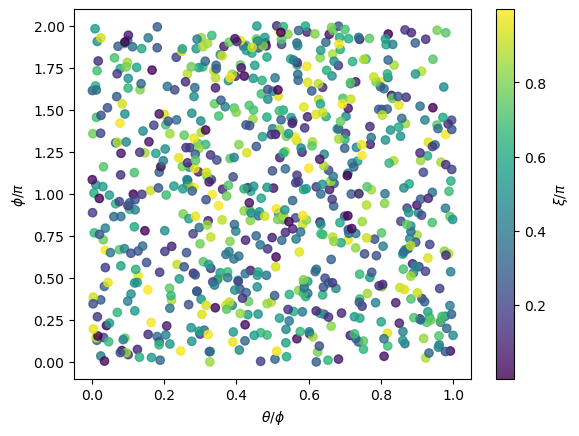

In [ ]:
ss_thetas = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_phis = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_xis = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_Phi0s = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
print(ss_thetas.shape)
plt.scatter(ss_thetas/np.pi, ss_phis/np.pi, c=ss_xis/np.pi, cmap='viridis', alpha=0.8)
plt.xlabel(r'$\theta/\phi$')
plt.ylabel('$\phi/\pi$')
plt.colorbar(label=r'$\xi/\pi$ ')

## 4.2 Unitary vectors

$$\hat{m} = +[\sin (\phi)\cos(\xi) - \sin (\xi) cos(\phi) cos(\theta)] \hat{x} 

- [\cos (\phi) \cos(\xi) + \sin(\xi) \sin(\phi) \cos(\theta)] \hat{y} 

+ [\sin)(\xi)\sin(\phi)]\hat{z} \quad\quad\quad(40)$$

$$ \hat{n} = +[-\sin(\phi) \sin(\xi) - \cos(\xi) \cos(\phi) \cos(\theta)] \hat{x} 
+[\cos(\phi) \sin(\xi) - \cos(\xi) \sin(\phi) \cos(\theta)] \hat{y} 
+[\cos(\xi) \sin(\theta)]\hat{z} \quad\quad\quad(41)$$

$$\hat{\Omega} = -\sin(\theta) \cos(\phi) \hat{x}  - \sin(\theta) \sin(\phi) \hat{y} - \cos(\theta) \hat{z} \quad\quad\quad(42)$$

These are functions of $\theta$ and $\phi$, the angular position of the binary, and $\xi$, the inclination of the binary. 

In [ ]:
def _m_unitary_vector(theta, phi, xi):
    """ Calculate the unitary vector m-hat for the antenna pattern functions.
    
    Parameters
    ----------
    theta : (F,R) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R) NDarray
        Spherical coordinate position of each single source.
    xi : (F,R) NDarray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    m_hat : (3,F,R) NDarray 
        Unitary vector m-hat with x, y, and z components at 
        index 0, 1, and 2, respectively.
        
    """
    mhat_x = (np.sin(phi) * np.cos(xi) 
              - np.sin(xi) * np.cos(phi) * np.cos(theta))
    mhat_y = -(np.cos(phi) * np.cos(xi)
               + np.sin(xi) * np.sin(phi) * np.cos(theta))
    mhat_z = (np.sin(xi) * np.sin(theta))

    m_hat = np.array([mhat_x, mhat_y, mhat_z])
    return m_hat

def _n_unitary_vector(theta, phi, xi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,) NDarray
        Spherical coordinate position of each single source.
    xi : (F,) 1Darray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    n_hat : (3,F,R) NDarray
        Unitary vector n-hat.
        
    """

    nhat_x = (- np.sin(phi) * np.sin(xi) 
              - np.cos(xi) * np.cos(phi) * np.cos(theta))
    nhat_y = (np.cos(phi) * np.sin(xi) 
              - np.cos(xi) * np.sin(phi) * np.cos(theta))
    nhat_z = np.cos(xi) * np.sin(theta)

    n_hat = np.array([nhat_x, nhat_y, nhat_z])
    return n_hat

def _Omega_unitary_vector(theta, phi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R) NDarray
        Spherical coordinate position of each single source.
    
    Returns
    -------
    Omega_hat : (3,F,R,) NDarray
        Unitary vector Omega-hat.
    """

    Omegahat_x = - np.sin(theta) * np.cos(phi)
    Omegahat_y = - np.sin(theta) * np.sin(phi)
    Omegahat_z = - np.cos(theta)

    Omega_hat = np.array([Omegahat_x, Omegahat_y, Omegahat_z])
    return Omega_hat



In [ ]:
m_hat = _m_unitary_vector(ss_thetas, ss_phis, ss_xis)
n_hat = _n_unitary_vector(ss_thetas, ss_phis, ss_xis)
Omega_hat = _Omega_unitary_vector(ss_thetas, ss_phis)
print(m_hat.shape, holo.utils.stats(np.sum(m_hat**2, axis=1)), '\n', 
      n_hat.shape, holo.utils.stats(np.sum(n_hat**2, axis=1)), '\n',  
      Omega_hat.shape, holo.utils.stats(np.sum(Omega_hat**2, axis=1))) # should all be 1
print(m_hat.shape, m_hat[:,0,0])
print(n_hat.shape, n_hat[:,0,0])
print(Omega_hat.shape, Omega_hat[:,0,0])

(3, 25, 30) 4.03e+00, 4.98e+00, 6.42e+00, 8.53e+00, 1.03e+01, 1.14e+01, 1.29e+01 
 (3, 25, 30) 4.09e+00, 5.07e+00, 6.32e+00, 8.29e+00, 1.06e+01, 1.18e+01, 1.26e+01 
 (3, 25, 30) 2.80e+00, 4.30e+00, 5.36e+00, 7.71e+00, 1.20e+01, 1.31e+01, 1.50e+01
(3, 25, 30) [-0.15543875 -0.98784316  0.00216217]
(3, 25, 30) [ 0.83356894 -0.12998828  0.53690396]
(3, 25, 30) [-0.53009585  0.085258    0.8436406 ]


Compare to hasasia, using just the 0th realization
* Omega_hat ($\hat{\Omega}$ in Rosado+2015) -> hsky.K ($\hat{k}$ in Hazboun+2019)
* m_hat ($\hat{m}$ in Rosado+2015) -> hsky L ($\hat{l}$ in Hazboun+2019)
* n_hat ($\hat{n}$ in Rosado+2015) -> hsky M ($\hat{m}$ in Hazboun+2019), -M if we use $\pi - \theta$ for colatitude

In [ ]:
# compare using just the 0th realization
# thetas_gw = np.pi - ss_thetas[:,0]  # pi - latitude gives colatitude, which reverses the sign of hsky.M
thetas_gw = ss_thetas[:,0]
phis_gw = ss_phis[:,0]
skymap = hsky.SkySensitivity(spectra, thetas_gw, phis_gw)
print('K of 0th freq source:', skymap.K[:,0],
      '\nL of 0th freq source:', skymap.L[:,0], 
      '\nM of 0th freq source:', skymap.M[:,0])
print('\nOmega-hat', Omega_hat[:,0,0],
      '\nm-hat:', m_hat[:,0,0],
      '\nn-hat', n_hat[:,0,0])

K of 0th freq source: [-0.53009585  0.085258    0.8436406 ] 
L of 0th freq source: [-0.15879434 -0.98731168  0.        ] 
M of 0th freq source: [ 0.83293622 -0.13396536  0.53690832]

Omega-hat [-0.53009585  0.085258    0.8436406 ] 
m-hat: [-0.15543875 -0.98784316  0.00216217] 
n-hat [ 0.83356894 -0.12998828  0.53690396]


## 4.3 Pulsar unitary vector
$$ \hat{p}_i = \sin(\theta_i) \cos(\phi_i) \hat{x} + \sin(\theta_i) \sin(\phi_i) \hat{y} + \cos(\theta_i) \hat{z} \quad\quad\quad(43)$$
where $\theta_i$ and $\phi_i$ give the angular position of the ith pulsar.

In [ ]:
def _pi_unitary_vector(phi_i, theta_i):
    """ Calculate the unitary vector p_i-hat for the ith pulsar.
    
    Parameters
    ----------
    phi : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    theta : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    Returns
    -------
    pi_hat : (3,P,) vector
        pulsar unitary vector
    
    """

    pihat_x = np.sin(theta_i) * np.cos(phi_i)
    pihat_y = np.sin(theta_i) * np.sin(phi_i)
    pihat_z = np.cos(theta_i)

    pi_hat = np.array([pihat_x, pihat_y, pihat_z])
    return pi_hat

In [ ]:
pi_hat = _pi_unitary_vector(phis, thetas)
print(holo.utils.stats(np.sum(pi_hat**2, axis=1))) # should all be 1
print(pi_hat.shape, pi_hat[:,0])

1.50e-32, 1.50e-32, 1.50e-32, 1.62e+00, 2.38e+00, 2.38e+00, 2.38e+00
(3, 4) [-1.52685855e-01 -9.88274774e-01  6.12323400e-17]


## 4.4 Antenna Pattern Functions
$$ F_i^+ = \frac{1}{2}  \frac{[\hat{m}\cdot \hat{p}_i]^2 - \hat{n} \cdot \hat{p}_i]^2}{1  + \hat{\Omega} \cdot \hat{p}_i} $$
 
 $$ F_i^\times = \frac{\hat{m} \cdot \hat{p}_i] [\hat{n} \cdot \hat{p}_i]}{1 + \hat{\Omega} \cdot \hat{p}_i}

In [ ]:
def dotprod(vec1, vec2):
    """ Calculate the dot product for NDarrays of 3D vectors, with
     vector elements specified by the first index. 
     
     Parameters
     ----------
     vec1 : (3,N1,N2,N3,...N) NDarray
     vec2 : (3,N1,N2,N3,...N) NDarray

     Returns
     -------
     dotted : (N1,N2,N3,...N) NDarray
        The dot product of the vectors specified by the first dimension,
        for every N1, N2, N3,...N.

    Example: find the dot product of 3D vectors for every P,F,R, using NDarrays
    of shape (3,P,F,R)
     """
    
    dotted = vec1[0,...]*vec2[0,...] + vec1[1,...]*vec2[1,...] + vec1[2,...]*vec2[2,...]
    return dotted


def _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat):
    """ + antenna pattern function for the ith pulsar.
    
    Parameters
    ----------
    m_hat : (3,F,R) NDarray
        Single source m_hat unitary vector for each frequency and realization.
    n_hat : (3,F,R) NDarray
        Single source mnhat unitary vector for each frequency and realization.
    Omega_hat : (3,F,R) NDarray
        Single source Omega_hat unitary vector for each frequency and realization.
    pi_hat : (3,P) NDarray
        Pulsar term unitary vector for the ith pulsar.
        
    Returns
    -------
    Fi_plus : (P,F,R) NDarray
        Plus antenna pattern function for each pulsar and binary of each realization.
    Fi_cross : (P,F,R) NDarray
        Cross antenna pattern function for each pulsar and binary of each realization. 
    
    """
    mh = m_hat[:,np.newaxis,:,:]
    nh = n_hat[:,np.newaxis,:,:]
    Oh = Omega_hat[:,np.newaxis,:,:]
    ph = pi_hat[:,:,np.newaxis,np.newaxis]
    denom = 1 + dotprod(Oh, ph)
    Fi_plus = ((dotprod(mh, ph)**2 - dotprod(nh, ph)**2) 
               / denom / 2)
    Fi_cross = dotprod(mh, ph) * dotprod(nh, ph) / denom
    
    return Fi_plus, Fi_cross
    

In [ ]:
Fi_plus, Fi_cross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat)
print(Fi_plus.shape, holo.utils.stats(Fi_plus))
print(Fi_cross.shape, holo.utils.stats(Fi_cross))

(4, 25, 30) -9.77e-01, -6.55e-01, -4.22e-01, 1.05e-03, 4.23e-01, 6.56e-01, 9.99e-01
(4, 25, 30) -9.92e-01, -6.79e-01, -4.12e-01, 1.65e-03, 4.29e-01, 6.63e-01, 9.99e-01


compare to hasasia

## 4.5 Amplitude, A

$$ A = 2 \frac{G^{5/3} \mathcal{M}^{5/3} [\pi f [1+z]]^{2/3}}{c^4 r} \quad (5)$$
$ h = A\sqrt{\frac{1}{2}[a^2+b^2]} \quad (4)$ ?? a and b are defined by i, is that related to hc_ss then??
$$ h_s = \frac{8}{10^{1/2}} \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (2\pi f_r)^{2/3}  = \frac{2^{2/3}\times8}{2\times10^{1/2}} \times \big[ 2 \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (\pi f_r)^{2/3} \big] =  \frac{4(2)^{1/6}}{\sqrt{5}} A $$
$$ h_{c,ss}^2 = h_s^2 / dlnf = h_s^2 * f / df $$
$$ h_{c,ss} = h_s \sqrt{f/df} \frac{4(2)^{1/6}}{\sqrt{5}} A * f / df$$
$$ A = \frac{\sqrt{5}}{4 (2)^{1/6}} \sqrt{\frac{df}{f}} h_{c,ss} $$

In [ ]:
def _amplitude(hc_ss, f, df):
    """ Calculate the amplitude from the single source to use in DP calculations
    
    Parameters
    ----------
    hc_ss : (F,R,) NDarray
        Characteristic strain of each single source at each realization.
    f : (F,) 1Darray
        Frequency
    df : (F,) 1Darray
        Frequency bin widths.

    Returns
    -------
    Amp : (F,R,)
        Dimensionless amplitude, A, of each single source at each frequency and realization.
    
    """

    Amp = hc_ss * np.sqrt(5) / 4 / 2**(1/6) *np.sqrt(df[:,np.newaxis]/f[:,np.newaxis])
    return Amp

In [ ]:
df = np.diff(edges[-1])
amp = _amplitude(hc_ss, fobs, df)
print(amp.shape, holo.utils.stats(amp))

(25, 30) 3.63e-18, 1.04e-17, 1.70e-17, 4.82e-17, 1.69e-16, 3.40e-16, 1.20e-15


## 4.6 ss_noise
Noise from all other sources in the same frequency bin except for the loudest
$$ S_{h,\mathrm{rest}} = \frac{h_{c,\mathrm{rest}}^2}{f} \frac{1}{12 \pi^2 f^2} \quad\quad\quad(45)$$
Included in total noise spectral density for the ith pulsar
$$S_i = 2\Delta t \sigma_i^2 + S_{h,\mathrm{rest}}\quad\quad\quad(44)$$

In [ ]:
def _Sh_rest_noise(hc_bg, freqs):
    """ Calculate the noise spectral density contribution from all but the current single source, i.e., the background.

    Parameters
    ----------
    hc_bg : (F,R,) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    ss_noise : (P,F,R,) NDarray of scalars
        The noise in each pulsar for detecting a single source at each frequency.

    Follows Eq. (45) in Rosado et al. 2015.
    TODO: modify this to allow for multiple loud sources.
    """
    Sh_rest = hc_bg**2 / freqs[:,np.newaxis]**3 /(12 * np.pi**2) # (F,R)
    return Sh_rest

# otherwise calculate from scratch
def _total_noise(delta_t, sigmas, hc_bg, freqs):
    """ Calculate the noise spectral density of each pulsar, s it pertains to single
    source detections, i.e., including the background as a noise source. 

    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigmas : (P,) 1Darray
        Variance for the ith pulsar, in seconds
    hc_bg : (F,R,) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    noise : (P,F,R,) NDarray of scalars
        The noise in each pulsar for detecting a single source at each frequency.

    Follows Eq. (44) in Rosado et al. 2015.
    """

    noise = _white_noise(delta_t, sigmas) # (P,)
    Sh_rest = _Sh_rest_noise(hc_bg, freqs) # (F,R,)
    noise = noise[:,np.newaxis,np.newaxis] + Sh_rest[np.newaxis,:] # (P,F,R)
    return noise

In [ ]:
tot_noise = _total_noise(cad, sigmas, hc_bg, fobs)
print(tot_noise.shape, holo.utils.stats(tot_noise))

(4, 25, 30) 1.26e-07, 1.26e-07, 1.26e-07, 1.26e-07, 1.39e-07, 5.90e-07, 1.24e-05


## 4.7 Polarization contributions
$$ a = 1 + \cos^2 \iota $$
$$ b = -2 \cos \iota $$

Where $\iota$ is the binary inclination angle.

In [ ]:
def _a_b_polarization(iotas):
    """ Polarization contribution variables a and b.
    
    Parameters
    ----------
    iotas : scalar or NDarray
        Typically will be (F,R,) NDarray

    Returns
    -------
    a_pol : scalar or NDarray
        Same shape as iota
    b_pol : scalar or NDarray
        Same shape as iota

    """
    a_pol = 1 + np.cos(iotas) **2
    b_pol = -2 * np.cos(iotas)
    return a_pol, b_pol

In [ ]:
ss_iotas = ss_xis
a_pol, b_pol = _a_b_polarization(ss_iotas)

## 4.8 GW Phase
$\Phi_0$ is the initial phase and describes the signal detected on Earth. $\Phi(t) = 2\pi f t$, and 
$$\Phi_T = 2 \pi f T \quad\quad\quad (47)$$ 
where $T$ is the duration. 

In [ ]:
def _gw_phase(dur, freqs):
    """ Calculate the detected gravitational wave phase at each frequency.

    Parameters
    ----------
    dur : scalar
        Duration (time elapsed from initial phase to detection)
    freqs : (F,) 1Darray
        Frequency of each single source.

    Returns
    -------
    Phi_T : (F,) NDarray
        Detected GW phase of each single source.
    """

    Phi_T = 2 * np.pi * freqs
    return Phi_T

## 4.9 SNR 
### 4.9.1 SNR for a single pulsar
$$ \mathrm{S/N}_i^2 = \frac{A^2}{S_i 8 \pi^3 f^3} \bigg[a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)]
+ \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] \\
+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] \\
- 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) 
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big]\bigg]\quad\quad\quad(46) $$

### 4.9.2 Total SNR (for each single source)
$$\mathrm{S/N_S} = \Big[ \sum_{i=1}^{M} \mathrm{S/N}_i^2\Big]^{1/2} \quad\quad\quad(35)$$

breaking up the SNR_i equation into pieces:
$$ \mathrm{Term 1} = a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)] + \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] $$
$$ \mathrm{Term 2} =+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] $$
$$\mathrm{Term 3} = - 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) \\
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big] $$

$$\mathrm{Coef} =  \frac{A^2}{S_i 8 \pi^3 f^3}$$
$$S/N_i^2 = \mathrm{Coef} \bigg[\mathrm{Term1} + \mathrm{Term2} + \mathrm{Term3}\bigg]$$

In [ ]:
def _SNR_ss(amp, Fi_plus, Fi_cross, iotas, dur, Phi_0, S_i, freqs):
    """ Calculate the SNR for each pulsar wrt each single source detection.

    Paramters
    ---------
    amp : (F,R,) NDarray 
        Dimensionless strain amplitude for loudest source at each frequency.
    Fi_plus : (P,F,R,) NDarray
        Antenna pattern function for each pulsar.
    Fi_cross : (P,F,R,) NDarray
        Antenna pattern function for each pulsar.
    iotas : (F,R,) NDarray
        Is this inclination? or what?
        Gives the wave polarizations a and b.
    dur : scalar
        Duration of observations.
    Phi_0 : (F,R,) NDarray
        Initial GW Phase.
    S_i : (P,F,R,) NDarray
        Total noise of each pulsar wrt detection of each single source, in s^3
    freqs : (F,) 1Darray 

    Returns
    -------
    SNR_ss : (F,R,) NDarray
        SNR from the whole PTA for each single source at each frequency and realization.

    """
    
    amp = amp[np.newaxis,:,:]  # (P,F,R)
    # print('amp', amp.shape)

    a_pol, b_pol = _a_b_polarization(iotas) # (F,R,)
    a_pol = a_pol[np.newaxis,:,:] # (P,F,R)
    b_pol = b_pol[np.newaxis,:,:] # (P,F,R)
    # print('a_pol', a_pol.shape)
    # print('b_pol', b_pol.shape)

    Phi_T = _gw_phase(dur, freqs) # (F,)
    # print('Phi_T', Phi_T.shape)
    Phi_T = Phi_T[np.newaxis,:,np.newaxis] # (P,F,R)
    # print('Phi_T', Phi_T.shape)

    Phi_0 = Phi_0[np.newaxis,:,:] # (P,F,R)
    # print('Phi_0', Phi_0.shape)

    freqs = freqs[np.newaxis,:,np.newaxis]
    # print('freqs', freqs.shape)

    coef = amp**2 / (S_i * 8 * np.pi**3 * freqs**3) # [S_i] s^3 and [freqs^3] Hz^3 cancel
    
    term1 = a_pol**2 * Fi_plus**2 * (Phi_T * (1 + 2 * np.sin(Phi_0)**2) 
                                     + np.cos(Phi_T)*(-np.sin(Phi_T) + 4 * np.sin(Phi_0)) 
                                     - 4*np.sin(Phi_0))
    
    term2 = b_pol**2 * Fi_cross**2 * (Phi_T*(1+2*np.cos(Phi_0)**2) 
                                      + np.sin(Phi_T)*(np.cos(Phi_T) - 4 * np.cos(Phi_0)))
    
    term3 = - (2*a_pol*b_pol*Fi_plus*Fi_cross 
               * (2*Phi_T*np.sin(Phi_0)*np.cos(Phi_0)
                  + np.sin(Phi_T)*(np.sin(Phi_T) - 2*np.sin(Phi_0) 
                                   + 2*np.cos(Phi_T)*np.cos(Phi_0) 
                                   - 2*np.cos(Phi_0))))
    
    SNR_pulsar_ss = coef*(term1 + term2 + term3) # (P,F,R)

    SNR_ss = np.sqrt(np.sum(SNR_pulsar_ss**2, axis=0)) # (F,R)
    return SNR_ss

In [ ]:
SNR_ss = _SNR_ss(amp=amp, Fi_plus=Fi_plus, Fi_cross=Fi_cross, iotas=ss_iotas,
                 dur = dur, Phi_0=ss_Phi0s, S_i=tot_noise, freqs=fobs)
print(SNR_ss.shape, holo.utils.stats(SNR_ss))

amp (1, 25, 30)
a_pol (1, 25, 30)
b_pol (1, 25, 30)
Phi_T (25,)
Phi_T (1, 25, 1)
Phi_0 (1, 25, 30)
freqs (1, 25, 1)
(25, 30) 4.97e-21, 1.61e-15, 1.38e-14, 4.15e-13, 2.79e-11, 1.98e-10, 5.69e-09


## 4.10 Threshold F-statistic $\cal{\bar{F}}_e$ 

Calculated from
$$ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N \quad\quad\quad(31)$$
where $\alpha_0$ is the fixed value false alarm probability and $N$ is the number of single sources (in that realization).

$$ 0 = \alpha_0 - 1 + [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N$$
Note, this is the same across all realizations, since it just depends on the number of single sources.

In [ ]:
def _func_Fe_thresh(Fe_bar, Num, alpha_0):
    rv = alpha_0 - 1 + (1 - (1 + Fe_bar)*np.exp(-Fe_bar))**Num 
    return rv

def _Fe_thresh(Num, alpha_0=0.001):
    """ Calculate the threshold F_e statistic.
    
    Parameters
    ----------
    Num : int
        Number of single sources to detect.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    Fe_bar : scalar
        Threshold Fe statistic
    """
    
    Fe_bar = sp.optimize.fsolve(_func_Fe_thresh, 1, args=(Num, alpha_0))[0]
    return Fe_bar


In [ ]:
Num = hc_ss[...,0].size # does not depend on realizations
print(Num)
Fe_bar = _Fe_thresh(Num)
print(Fe_bar)

25
51.0


## 4.11 Detection Probability
### 4.11.1 DP of one single source
$$\gamma_i = \int_{\cal{\bar{F}}_e}^\infty p_1(\cal{F}_e, \rho) d \cal{F}_e \\
= \int_{\cal{\bar{F}}_e}^\infty \frac{[2\cal{F}_e]^{1/2}}{\rho} I_1(\rho\sqrt{2\cal{F}_e}) e^{-\cal{F}_e-\frac{1}{2} \rho^2} d\cal{F}_e$$
with $\rho=\mathrm{S/N_i}$ and $\cal{\bar{F}}_e$ calculated from $ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N$ where $N$ is the number of single sources (in that realization)

In [ ]:
def _integrand_gamma_ss_i(Fe, rho):

    I_1 = sp.special.i1(rho*np.sqrt(2*Fe_bar))
    rv = (2*Fe)**(1/2) /rho * I_1 * np.exp(-Fe - rho**2 /2)
    return rv

def _gamma_ss_i(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ss_i : (F,R,) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for loops!
    """
    gamma_ss_i = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            gamma_ss_i[ff,rr] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr]))[0]
   
    return gamma_ss_i



In [ ]:
gamma_ss_i = _gamma_ss_i(Fe_bar, rho=SNR_ss)
print(gamma_ss_i.shape, holo.utils.stats(gamma_ss_i))

(25, 30) 3.65e-21, 3.65e-21, 3.65e-21, 3.65e-21, 3.65e-21, 3.65e-21, 3.65e-21


### 4.11.2 Detection Probability of any single source
$$\gamma_{ss} = 1 - \prod_{i}[1-\gamma_i]$$

In [ ]:
def _ss_detection_probability(gamma_ss_i):
    """ Calculate the probability of detecting any single source, given individual single 
    source detection probabilities.
    
    
    Parameters
    ----------
    gamma_ss_i : (F,R,) NDarray
        Detection probability of each single source, at each frequency and realization.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Detection probability of any single source, for each realization
    """
    
    gamma_ss = 1 - np.product(1-gamma_ss_i, axis=1)
    return gamma_ss

In [ ]:
gamma_ss = _ss_detection_probability(gamma_ss_i)
print(gamma_ss.shape, holo.utils.stats(gamma_ss))
print(gamma_ss)

(25,) 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
